In [2]:
# %load_ext lab_black
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
!pip install lets-plot
!pip install pymc3

In [4]:
import pymc3 as pm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy

import lets_plot as lp
import seaborn as sns

sns.set()
lp.LetsPlot.setup_html()
plt.rcParams["figure.figsize"] = (12, 8)

### Manually derived posterior

We'll first look at the posterior distribution we derived manually:

\begin{equation}
p(\theta | n, \alpha, \beta) = \frac{\theta^{n + \alpha -1} (1- \theta)^{(N-n+\beta-1)}}{B(\alpha + n, \beta + N -n)}
\end{equation}

Here, let's say we took our Beta prior to be $Beta(4, 4)$. Also, let's say we've tossed the coin `N=50` times and we got `n=32` heads.

```
alpha = 4
beta = 4
N = 50
n = 32
```

In [5]:
alpha = 4
beta = 4
N = 50
n = 32

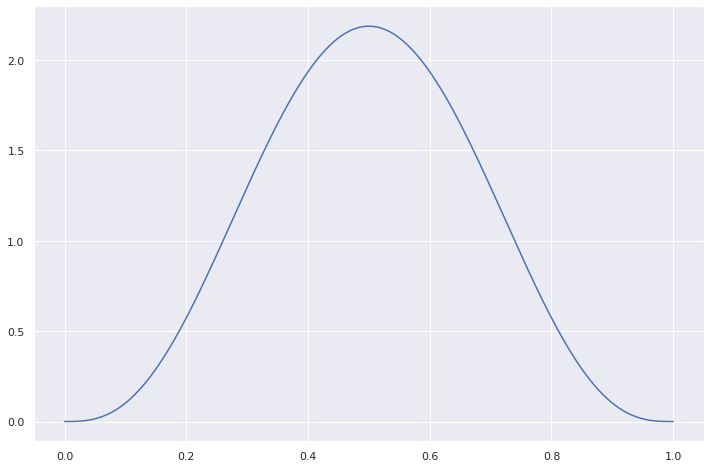

In [6]:
# Let's look at the prior
plt.plot(np.linspace(0, 1, 5000), scipy.stats.beta.pdf(np.linspace(0, 1, 5000), 4, 4))

In [7]:
x_dist = np.linspace(0, 1, 5000)
y_dist = scipy.stats.beta.pdf(x_dist, alpha + n, beta + N - n)

We'll plot the hand calculated posterior along with the 'simple' estimate of 32/50 = 0.64 in red

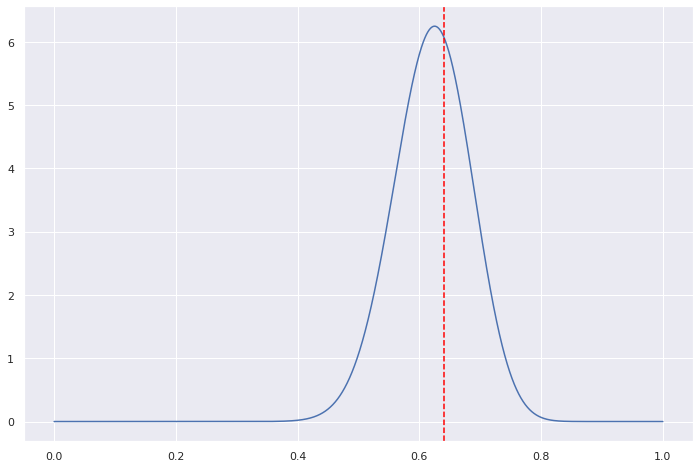

In [8]:
fig, ax = plt.subplots()
ax.plot(x_dist, y_dist)
ax.axvline(x=n / N, color="red", linestyle="--")

As an aside, here is the same hand calculated prior in the case we got 4 heads and 1 tails (the example from the presentation)

In [9]:
# also repeat with 4 heads, 1 T

In [10]:
x_dist = np.linspace(0, 1, 5000)
y_dist = scipy.stats.beta.pdf(x_dist, alpha + 4, beta + 5 - 4) # we're just plugging values in the formula we calculated (see above)

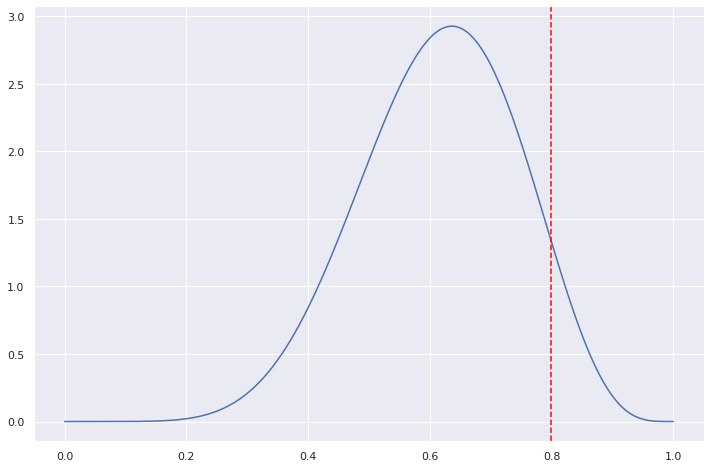

In [11]:
fig, ax = plt.subplots()
ax.plot(x_dist, y_dist)
ax.axvline(x=4 / 5, color="red", linestyle="--")

Now, we'll go back to our original case, `n=32`, `N=50`

#### We will generate the plot for posterior of P(H) with PyMC3

We'll describe the process to PyMC3:
- We pull a P(H) from a Beta prior
- We then do Bernoulli Trial with this value of P(H)
- We observe the results which we feed into to the model

In [12]:
data = ([1] * n) + ([0] * (N - n))
print(data)

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7faf57bb2910>,
      dtype=object)

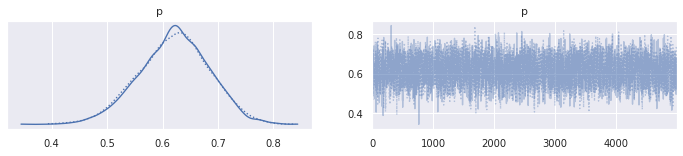

In [13]:
with pm.Model() as coin_flipping:
    p = pm.Beta("p", alpha, beta)
    y = pm.Bernoulli("y", p=p, observed=data)
    trace1 = pm.sample(5000, return_inferencedata=True, tune=1500)

pm.plot_trace(trace1)

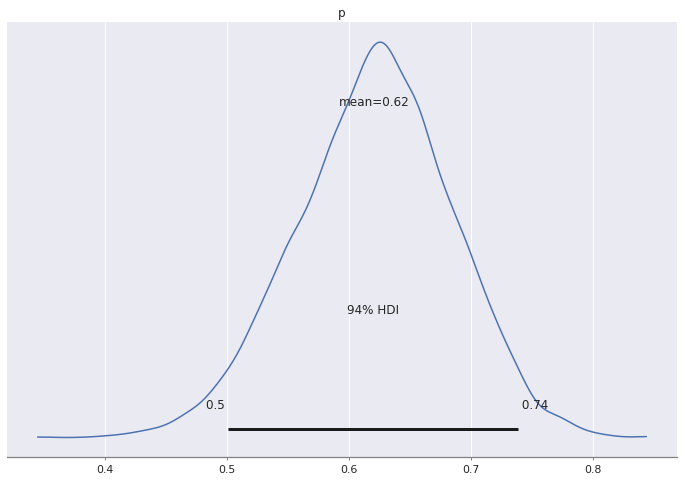

In [18]:
import arviz as az
az.plot_posterior(trace1)

We can also model the outcomes as a Binomial process with a proability of success, number of trials and number of observed successes.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7faf53c5a210>,
      dtype=object)

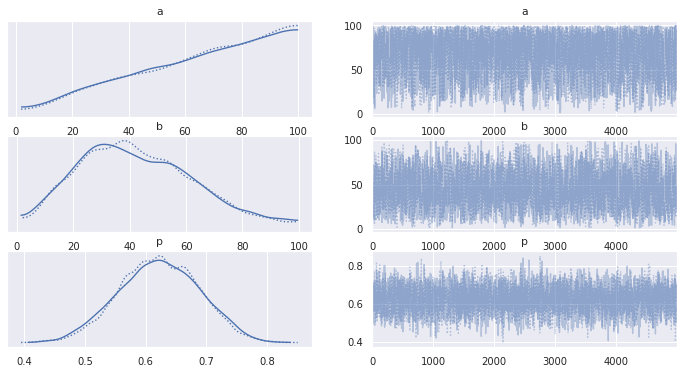

In [14]:
data = [n]

with pm.Model() as coin_flipping:
    a = pm.Uniform("a", 1, 100)
    b = pm.Uniform("b", 1, 100)
    p = pm.Beta("p", a, b)
    y = pm.Binomial("y", p=p, n=N, observed=data)
    trace2 = pm.sample(5000, return_inferencedata=True, tune=1500)

pm.plot_trace(trace2)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7faf4d37a690>,
      dtype=object)

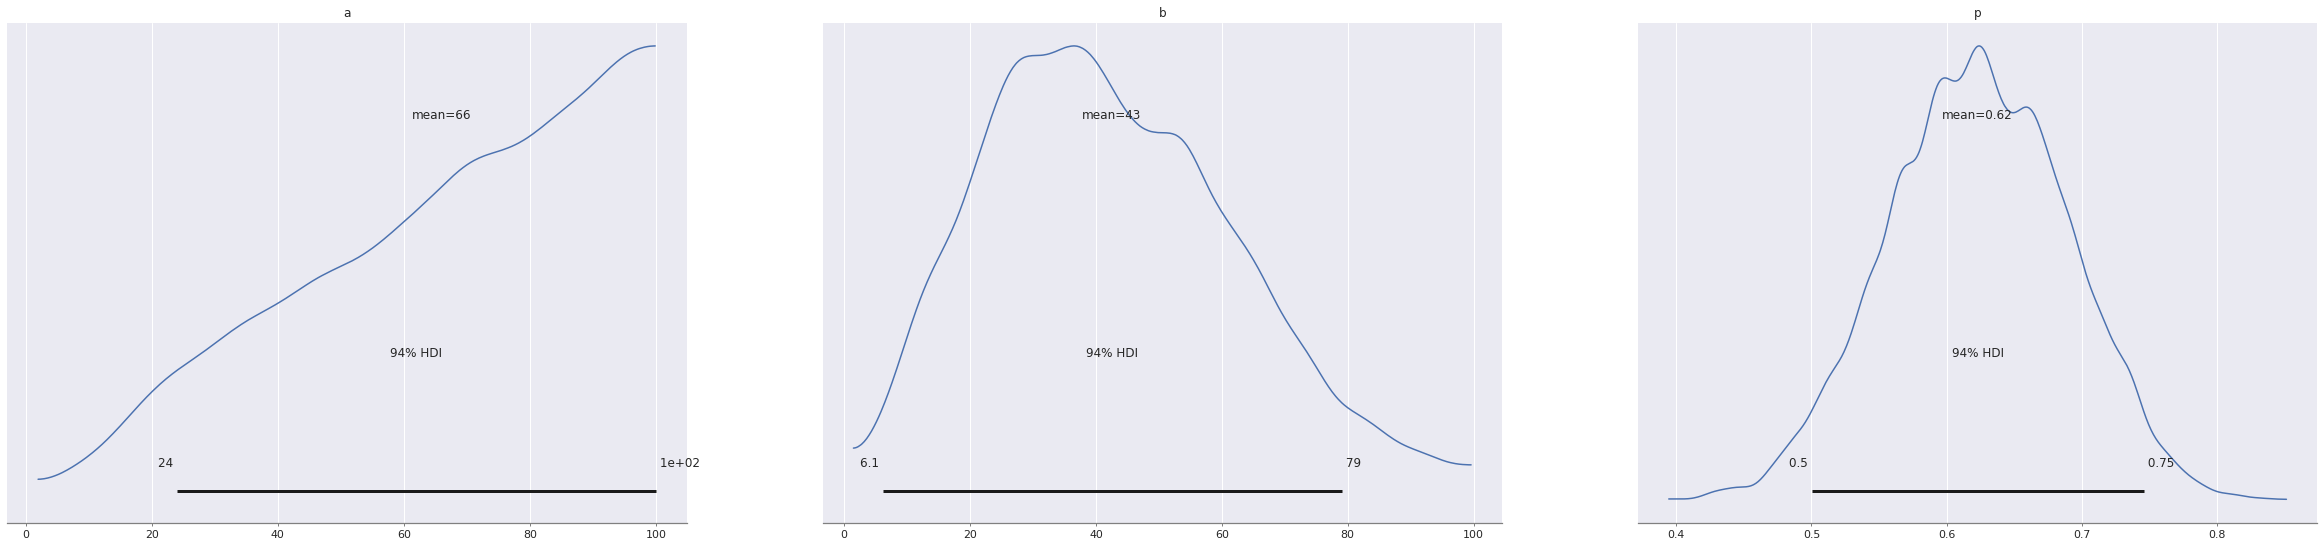

In [19]:
az.plot_posterior(trace2)

Lastly, we will plot all three plots here:
- In orange, the posterior distribution calculated by hand
- In blue, the posterior distribution calculated by modeling the data generating process as a Bernoulli process
- In green, the posterior distribution calculated by modeling the data generating process as a Binomial process

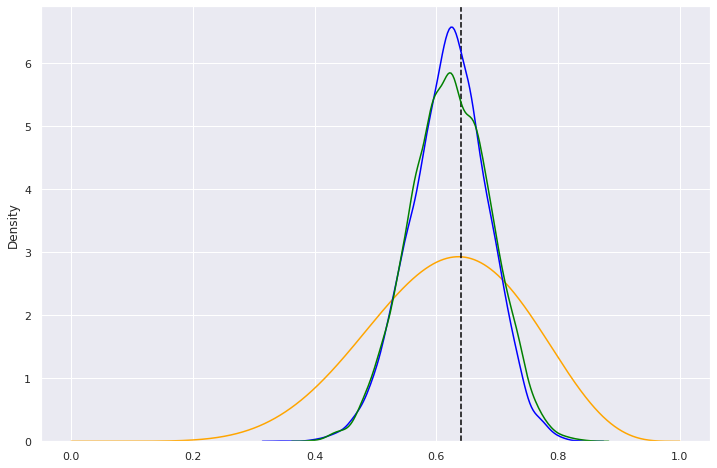

In [15]:
fig, ax = plt.subplots()

ax.plot(x_dist, y_dist, color="orange")
ax.axvline(x=n / N, color="black", linestyle="--")

sns.kdeplot(trace1.posterior["p"].values.flatten(), ax=ax, color="blue")
sns.kdeplot(trace2.posterior["p"].values.flatten(), ax=ax, color="green")

In [16]:
# try to expriment with U-shaped beta distribution 
# flat-priors imply no-preference for any value of the prior. In this case, MAP == MLE